In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
# clinical_data_path = 'data/clean/clinical/data.csv'
# output_path = 'data/clean/clinical/data_with_derived_variables.csv'

In [3]:
clinical_data = read_csv(
    clinical_data_path, index_col=0,
    parse_dates=['AdmissionDate', 'Birthday', 'DateDeath']
)

## Adding derived clinical variables:

### Age

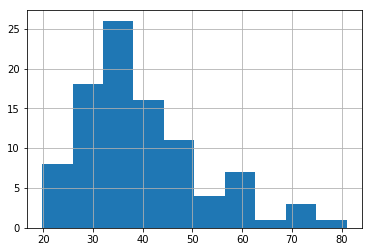

In [4]:
clinical_data['age_at_admission'] = clinical_data['AdmissionDate'] - clinical_data['Birthday']
clinical_data['age_at_admission_years'] = clinical_data['age_at_admission'].dt.days / 360
clinical_data['age_at_admission_years'].hist();

In [5]:
clinical_data['age_at_admission_years'].describe()

count    95.000000
mean     39.805058
std      12.397218
min      19.786111
25%      31.409722
50%      35.602778
75%      45.772222
max      80.966667
Name: age_at_admission_years, dtype: float64

In [6]:
clinical_data['age_at_admission_years'].round().median()

36.0

### Survival

In [7]:
clinical_data['survival'] = (
    clinical_data['DateDeath'] - clinical_data['AdmissionDate']
)
clinical_data['survival'].describe()

count                         22
mean     36 days 21:49:05.454545
std      46 days 02:28:45.945168
min              2 days 00:00:00
25%              9 days 06:00:00
50%             16 days 12:00:00
75%             30 days 06:00:00
max            161 days 00:00:00
Name: survival, dtype: object

The figures above describe only the 22 deceased patients. As the follow-up was 6 months:

In [8]:
follow_up = np.timedelta64(6, 'M')

In [9]:
clinical_data['censored_survival'] = clinical_data.survival.fillna(follow_up)
clinical_data['censored_survival'].tail()

PatientID
247.CM    182 days 14:54:36
248.TMD   182 days 14:54:36
255.VM    182 days 14:54:36
256.CM    182 days 14:54:36
261.CM     10 days 00:00:00
Name: censored_survival, dtype: timedelta64[ns]

Convert to days:

In [10]:
clinical_data['survival'] = clinical_data['survival'].dt.days
clinical_data['censored_survival'] = clinical_data['censored_survival'].dt.days

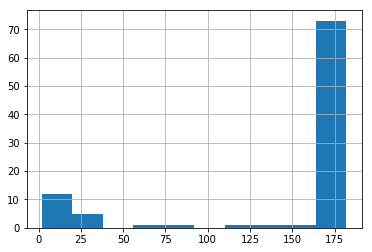

In [11]:
clinical_data['censored_survival'].hist();

### Adding disease data

Extract vectors with nicely formatted (and ordered) condition (disease) names:

In [12]:
from plots.annotations import conditions_names, tuberculosis_status

In [13]:
conditions_names

{'CM': 'Cryptococcal',
 'HC': 'Healthy control',
 'TMD': 'Tuberculosis',
 'TMR': 'Tuberculosis',
 'TMS': 'Tuberculosis',
 'VM': 'Viral',
 'BM': 'Bacterial'}

In [14]:
granular_conditions = clinical_data.index.str.split('.').str[1]
by_condition = granular_conditions.map(conditions_names)

In [15]:
clinical_data['Meningitis'] = by_condition

In [16]:
assert not clinical_data['Meningitis'].isnull().any()

In [17]:
tuberculosis_status

{'TMD': 'Definite', 'TMR': 'Probable', 'TMS': 'Possible'}

In [18]:
clinical_data['Tuberculosis'] = granular_conditions.map(tuberculosis_status).fillna('-')

### Saving expanded dataset

In [19]:
clinical_data.to_csv(output_path)

TODO: split into dependent/independent variables and confounders?

## Correlation of the clinical variables

TODO

## Which variables to use for analyses?

### Regression

We may want to regress on:
- symptoms severity (e.g. duration of lethargy, reduced consciousness, sickness, etc)
- some of the interval clinical variables (Level of glucose in CSF, CD4 count)
- ordinal variables (in between the regression and classification - ordinal/multinomial regression):
  - grade of TBM (1-3)
  - tuberculosis "certainty" status on the TB (+viral?) patients only

Variable selection:
 - lasso: per each objective (to determine the top proteins influencing each response variable)
 - differential "expression"

### Classification

- HIV status (logistic regression?)
- Patient group (4 meningitis groups)
- CSF appearance (4 combinations or 2x2)
